# How does BPM correlate with song popularity over time? #
A computational essay by Richard Li, Natsuki Sacks, Norah Evans 

# Introduction #

Over the past few years of human existence, *everything* has gotten faster. Instant deliveries, messaging, food, etc. A common critique of the 21st century is that it's built on speed. Our group wondered if that holds true for songs. Have we begun enjoying faster songs as everything around us accelerates?

In [7]:
# Import code for scraping and cleaning data
import requests
from bs4 import BeautifulSoup

# Methodology #

In order to answer our research question of whether the average tempo of the most popular songs has increased in the modern era, we must accomplish 3 things:

1. Find a metric for popularity among songs in a year
2. Find the BPM of those songs
3. Average the BPM and chart the trends over the course of many years

Each of these things occur in 3 files:
1. billboard.py
2. bpm.py
3. visualization.py

In [5]:
# Some dependencies for our code to work:
from time import sleep
from ast import literal_eval
import pandas as pd
import requests
from bs4 import BeautifulSoup
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import yaml

ModuleNotFoundError: No module named 'spotipy'



## Step One ##
We found this [Billboard Top 100](BillboardTop100of.com) website to scrape our data from. The Billboard Top 100 contains the rank, artist, and song for up to the top 100 songs for years 1940 to 2021. Some of the Top Billboards in the 40s contain only 30 to 80 songs, but beggars can't be choosers.

The metric for ranking on this website is based off of the Billboard Magazine, which has been keeping track of the music industry for years now.

### 1a. Scraping the Data ###
To analyze the data's BPM, we first need to scrape it from this website. We chose to scrape our data from the [Billboard Top 100](BillboardTop100of.com), since the APIs we found didn't provide all of the information we needed for free.

Each year contained a table made up of the song information for that year. To extract all of the information in that table (rank, artist, song), we used the Python Requests library to grab all of the data for a given year. We then parsed our data using BeautifulSoup, and then extracted all of the important information from that HTML parse by finding all data within a given tag (also by using Beautiful Soup).

In [ ]:
# The function we used to grab Billboard data for a given year.
def get_data(year):
    # Years 1940 and 2020 had different URLs than every other year 
    if year == (2020):
        url = "http://billboardtop100of.com/billboard-top-100-songs-2020-2/"
    elif year == 1940:
        url = "http://billboardtop100of.com/336-2/"
    else:
        url = f"http://billboardtop100of.com/{year}-2/"
    response = requests.get(url)
    data = BeautifulSoup(response.content, "html.parser")
    return data

We won't print out all of the data returns from the HTML Request, since it's pretty much a bunch of gibberish with some important information sprinkled in between. 

To figure out what tag we needed to look for, we went in to the [Billboard Top 100](BillboardTop100of.com) page for the given year and inspected an element that we needed (i.e. "The Weeknd"). We did end up doing this for about 15 pages or so, since years 1945 to 2014 (skipped 2013) had the same body tags, while all remaining years had varying tags. 

In [ ]:
data = get_data(2014)
music_data = data.findAll("p")

# Let's print part of the data to make it less overwhelming.
print(music_data[:16])

4


### 1b. Cleaning the Data ###
As we can see, `music_data` contains the information we need, but also contains a bunch of HTML code that we don't need. It also isn't formatted properly; at the end of all this, we want a list of lists that contain three string elements: the rank, artist, and song for all ~100 songs of the year.

For the more straightforward years, where each rank, artist, and song were already separated into a list of strings with random newlines or external links in between, the `remove_long_tags` function was used to clean all of that data by calling one line of code.

Some years had more convoluted tags, line breaks, external images, etc. stuck in between important information, so those were cleaned using the `remove_long_tags` function in addition to other `.replace` commands.

In [ ]:
# An example of what cleaning a less-messy data set looks like

# Removing all p-tags, "amp;", "/n", and more for 2014
clean_data = clean_data("<p", music_data)

# Removes all external links (images, additional information)
clean_data_more = clean_data("<a", clean_data)

# Splits the list of strings into a list of lists, grouping the strings into
# lists at intervals of three
split_list = split_list_into_three(clean_data_more)

# Let's print part of the resulting split list to make it less overwhelming
print(split_list[:6])

### 1c. Loading the Data into the Data Frame 
`split_list` is then loaded into the data frame using the `import_to_df` function in `billboard_functions.py`. This data frame is 80 columns (one for each year searched for, excluding 2021) by 100 rows (one for every song on the Billboard Top 100 for each year).

In [ ]:
# The function used to load the files into the data frame
def import_to_df(split_list, year, df):
    for i in range(1, len(split_list) + 1):
        df.at[i, year] = split_list[i - 1]
        
    df.to_csv("../data/top100.csv")

# Step Two
[Spotipy](https://spotipy.readthedocs.io/en/2.19.0/) is a python wrapper for Spotify's API. We use this in order to query spotify for the tempo information corresponding to the songs we found in step one. The end goal of step 2 is to produce a csv that contains the tempo data for all top 100 songs from 1940 to 2021.

In order to use it, we have to set up a client :

*The YAML config file is here so that we can save the token in a way that isn't accessible to everyone who views the Github repo. It's .gitignored to ensure it cannot be uploaded to the internet.*

In [ ]:
with open ("../config.yaml","r") as yaml_file:
    config = yaml.safe_load(yaml_file)

client_credentials_manager = SpotifyClientCredentials(
    client_id=config["SPOTIPY_CLIENT_ID"], client_secret=config["SPOTIPY_CLIENT_SECRET"])
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

### 2a. Parsing data from billboard.py ###
`billboard.py` produced the information we need: a csv file in which every cell is a list of three things: rank, song, artist (`data/top100.csv`). We can now create a dataframe containing that information so that we can easily manipulate it in python. We'll also want to create an empty dataframe that we'll fill out with information after querying Spotify for every song we find in `top100.csv`

In [ ]:
# Define a range of years that you'd like to start and stop querying
START_YEAR = 1940
END_YEAR = 2019

# Open the datafile from billboard scraping
song_df = pd.read_csv("../data/top100.csv").set_index("index")

# Initialize an empty dataframe where tempo information will be stored
tempo_df = pd.DataFrame(index=range(
    1, 101), columns=range(START_YEAR, END_YEAR+1))

### 2b. Querying Spotify ###
Now that we have a Spotify client open with spotipy, we can set up a function that we'll call repeatedly in order to find the information that we desire. Querying spotify for a song's "audio features" returns a list of many many things, including energy, danceability, and so on. However, we only care about a single metric: tempo.

In [ ]:
def query_spotify(track, artist):
    """
    Queries Spotify's API for the tempo information corresponding to a track by an artist.

    Args:
        track (str): the track to find bpm info for
        artist (str): the artist of that track

    Returns:
        audio_features["tempo] (int): an integer containing the BPM of that song

        OR

        ValueError: if no song is found corresponding to the query
    """
    search_query = track + ' ' + artist
    search_results = sp.search(q=search_query)
    uri = search_results["tracks"]["items"][0]["uri"]
    audio_features = sp.audio_features(uri)[0]
    return audio_features["tempo"]

### 2c. Filling out bpm.csv ###

Now, it's as simple as iterating through our top100 dataframe `song_df` and filling it out with the tempo information we get from spotify, dumping the result into our created dataframe `tempo_df`. You'll note that there are a few "try and except" clauses in the loop. This is because the data is, as previously mentioned, a little incomplete. Some years don't have all 100 songs, and some of the songs listed can't be found on Spotify. In order to recitfy both of these problems, we catch the exceptions that occur and fill out any problematic cells with `None`. This way, the cell won't influence the average and we'll still have data that is representative of the year.

In [ ]:
# Iterate through all of the years of data
for i in range(START_YEAR, END_YEAR+1):
    print("i is now: ", str(i))

    # Iterate through all 100 songs for each year
    for j in range(1, 101):
        print("we are now on the", str(j), "th song")

        # Each cell is a list, but it's saved as a string right now
        # literal_eval will evaluate it as a list
        try:
            next_entry = literal_eval(song_df[str(i)][j])

        # If there is no song in that cell go to next year
        except ValueError:
            break

        # Try to query spotify for BPM info
        try:
            # The track + artist will be the 2nd and 3rd element of the list in the cell
            tempo_df.at[j, i] = query_spotify(next_entry[1], next_entry[2])

        # If song isn't found, set the value as NaN so it doesn't mess with the average
        except Exception as e:
            print(e)

            tempo_df.at[j, i] = None

    # Pause to avoid over-requesting Spotify
    sleep(1)

Now, we can save this to a csv for visualization purposes.

In [ ]:
# Write the resulting dataframe to a CSV file that visualization.py can use
tempo_df.to_csv("../data/bpmFULL.csv")

## STEP THREE ##
It was important to visualize all the data in multiple ways in order to find trends. Without comparing each piece of data it would be impossible to gather evidence to suggest correlation between popularity and bpm.
 
Using the CSV file created in section 2, the data was put into three graphs to help visualize any present trends. Using the help of Pandas and Matplotlib we were able to plot the data into two line graphs and one scatter plot. Three functions were made to create these graphs: `yearvsbpm()`, `scatterplot()`, and `popularityvsbpm()`.
 
`yearvsbpm()` first takes an average of the bpm of every top 100 song in a particular year. Then it graphs the average bpm compared to the year the songs were popular.
 
`scatterplot()` groups together each decade of top 100 songs and assigns them a color. It then plots each song on its rank compared to its bpm.
 
`popularityvsbpm()` takes an average of the bpm of every song of a particular rank in every year data is present. It then graphs the average bpm compared to the rank the songs were at.

# Results #


In [14]:
import sys
import os
data_path = os.path.abspath("./data")
module_path = os.path.abspath("./scripts")
if module_path not in sys.path:
    sys.path.append(module_path)
if data_path not in sys.path:
    sys.path.append(data_path)
from visualization import scatterplot, yearvsbpm, popularityvsbpm

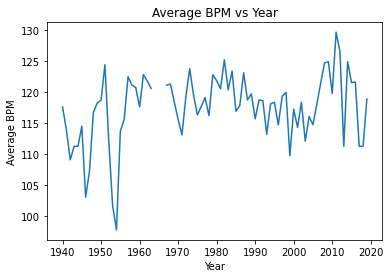

In [11]:
yearvsbpm()

This graph represents the average bpm of popular songs throughout the last 80 years. This allows us to look at bpm trends over time. This graph also shows a missing chunk of corrupted data in the 60s.

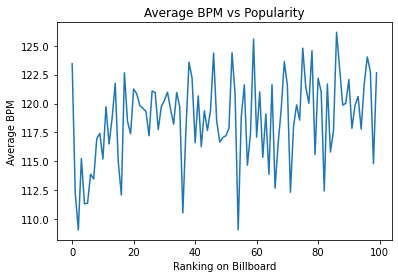

In [15]:
popularityvsbpm()

This graph represents the average bpm of a song of a particular rank throughout history. This graph allows us to look for trends about the popularity of a song compared to its bpm throughout the past 80 years of data.

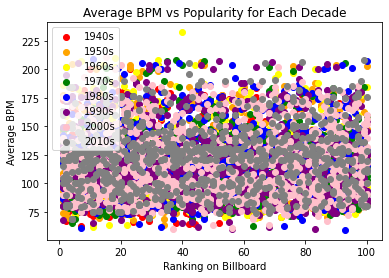

In [13]:
scatterplot()

This scatter plot allows the viewer to look at all data (year, popularity and bpm) at once. It displays trends per decade rather than year as well as 

# Interpretation #
Looking at the visualization of our data it is apparent that there are no obvious trends between popularity, bpm and year. Looking through the graphs there are dips in particular years but overall there seems to be no correlation between popularity and bpm over time. Although we tried to limit biases and inaccuracies, there are inherent problems with our data. Although BPM is the best way to express speed in a numerical format it is arbitrary and is affected by the time signature. Meaning a very slow song such as a waltz in 6/8 could have a comparable or even faster temp than a song with a time signature in 3/4 even cut time. Our data was extremely spotty in earlier years with less that 100 songs for most earlier decades. In the 1940s most of our data is christmas songs leading us to hypothesis that the data is the top 100 song in the present moment listened to from that era. There is also missing/corrupted data from the 60s that could have possible given us extra insight. A major lesson learned from this project is that is important to look at where all data is taken from and to choose well documented sites to scrape from. We found it was important to look at the failures of our model to understand its fallacies. This project highlights that other aspects of music are far more important than its speed which might help artists be successful in their careers. If we were to continue this project we would look at other variables that make music popular or try to expand the scope by using more years of data. It would also be interesting to contextualize this information with what is going on socially and historically.